<div class="alert alert-info">
    <h3 align = center>NLP based Real & Fake news classifier.</h3>
    
         
    
</div>

## Importing all the necessary `libraries`

In [8]:
import pandas as pd
import openpyxl
import numpy # version == 1.26.4
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
from spacy import displacy   
from spacy import tokenizer
import re
import spacy
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim 
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier 
from sklearn.metrics import accuracy_score, classification_report

In [9]:
# set plot options 
plt.rcParams['figure.figsize'] = (12,8)
default_plot_color = '#007acc'

                    

#### Reading the `datset.`

In [10]:
df = pd.read_excel(r"datasets/dataset.xlsx")
df.head(4)

# !Note -: `git rm --cached datasets/dataset.xlsx` removing because of large size of the file. 


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Data analysis of fake and factual news')

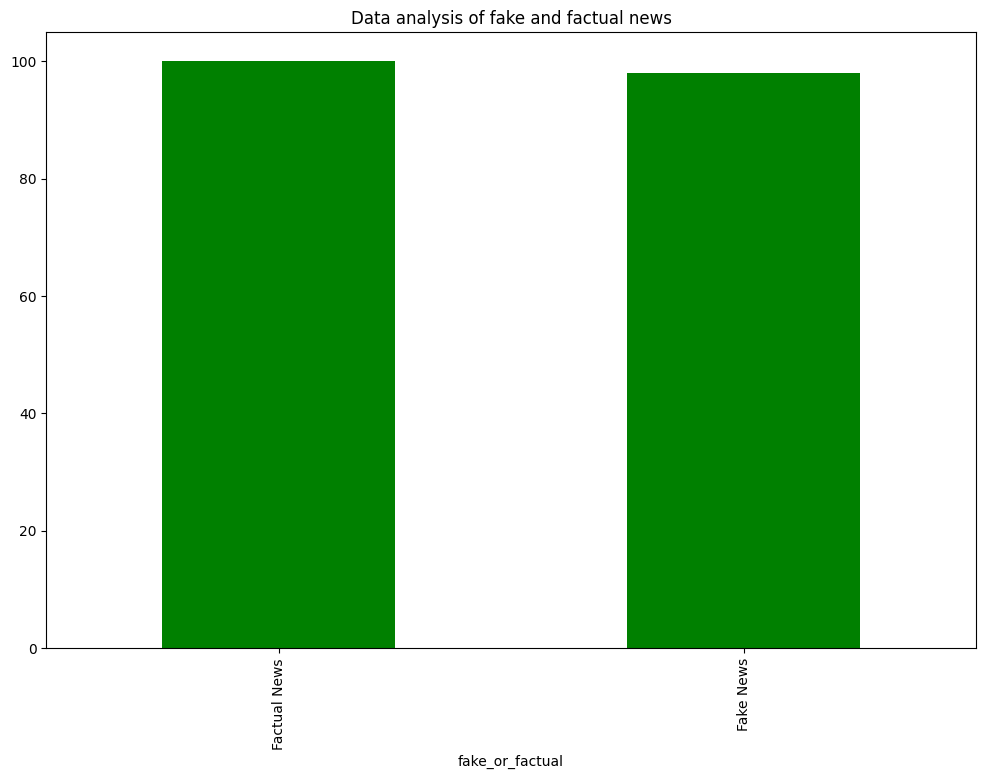

In [12]:
df['fake_or_factual'].value_counts().plot(kind='bar', color= "g")
plt.title('Data analysis of fake and factual news')

#### Here both the classes are almost same hence this is the perfect data set for data analysis.

POS TAGGING

In [13]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [14]:
fake_news = df[df['fake_or_factual']=='Fake News']
real_news = df[df['fake_or_factual']=='Factual News']

In [15]:
# Puting fake news text and the facts text in the nlp pipeline. 

fake_spacydocs = list(nlp.pipe(fake_news['text']))
fact_spacydocs = list(nlp.pipe(real_news['text']))

In [16]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text, i.ent_type_, i.pos_) for i in doc]

Start tagging the data set.

In [17]:
# start with fake data-set.
fake_tagsdf = []
columns = ["token", "ner_tag", "pos_tag"]

In [18]:
for ix, doc in enumerate(fake_spacydocs):
    tags = extract_token_tags(doc)
    # convert the tags in the data frame.
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)
    

In [19]:
fake_tagsdf = pd.concat(fake_tagsdf)

In [20]:
fact_tagsdf = []
for ix, doc in enumerate(fact_spacydocs):
    tags = extract_token_tags(doc)
    # convert the tags in the data frame.
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)


In [21]:
fact_tagsdf = pd.concat(fact_tagsdf)


##### 1. Data `tokenization` and `parts-of-speech` tagging.

In [22]:
fake_tagsdf.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [23]:
pos_counts_fake = fake_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by= 'counts')

pos_counts_fake.head(10)


,token,pos_tag,counts
4013,electronic,ADJ,1
4207,exposing,VERB,1
4206,expose,VERB,1
4204,export,NOUN,1
4202,explicit,ADJ,1
4199,explaining,VERB,1
4194,experience,VERB,1
4191,expelling,VERB,1
4190,expecting,VERB,1
4186,exodus,NOUN,1


In [24]:
pos_counts_fact = fact_tagsdf.groupby(['token', 'pos_tag']).size().reset_index(name='counts').sort_values(by= 'counts')

pos_counts_fact.head(10)


,token,pos_tag,counts
6651,…,PUNCT,1
4898,patrol,NOUN,1
4897,patriarch,NOUN,1
4896,path,NOUN,1
4895,patent,NOUN,1
4892,passport,NOUN,1
2522,cases,NOUN,1
4891,passing,VERB,1
2524,cash,VERB,1
4887,party,PROPN,1


In [25]:
pos_counts_fake.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2593
VERB     1813
PROPN    1669
ADJ       880
ADV       412
NUM       223
PRON       97
ADP        89
AUX        64
SCONJ      51
Name: token, dtype: int64

In [26]:
pos_counts_fact.groupby('pos_tag')['token'].count().sort_values(ascending=False).head(10)

pos_tag
NOUN     2180
VERB     1540
PROPN    1378
ADJ       748
ADV       263
NUM       204
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

Top 15 nouns -:


In [27]:
pos_counts_fake[pos_counts_fake.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
4204,export,NOUN,1
4186,exodus,NOUN,1
4185,exit,NOUN,1
4176,executives,NOUN,1
4169,excuses,NOUN,1
4239,factions,NOUN,1
4236,facility,NOUN,1
4226,fabric,NOUN,1
4223,eye,NOUN,1
4222,extremism,NOUN,1


In [28]:
pos_counts_fact[pos_counts_fact.pos_tag == 'NOUN'][:15]

,token,pos_tag,counts
4898,patrol,NOUN,1
4897,patriarch,NOUN,1
4896,path,NOUN,1
4895,patent,NOUN,1
4892,passport,NOUN,1
2522,cases,NOUN,1
2526,casualties,NOUN,1
2527,casualty,NOUN,1
2532,cause,NOUN,1
4883,partner,NOUN,1


##### 2. Extracting `named entities` between two groups. It is better to do it before any text pre processing & cleaning of the data.


In [29]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag']!= ""].groupby(['token', 'ner_tag']).size().reset_index(name = "counts").sort_values(by = 'counts', ascending = False)

In [30]:
top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag']!= ""].groupby(['token', 'ner_tag']).size().reset_index(name = "counts").sort_values(by = 'counts', ascending = False)

In [31]:
ner_palette = {
    'ORG': sns.color_palette("Set2").as_hex()[0],
    'GPE': sns.color_palette("Set2").as_hex()[1],
    'NORP': sns.color_palette("Set2").as_hex()[2],
    'DATE': sns.color_palette("Set2").as_hex()[3],
    'PERSON': sns.color_palette("Set2").as_hex()[4],
    'CARDINAL': sns.color_palette("Set2").as_hex()[5],
    'PERCENT': sns.color_palette("Set2").as_hex()[6]
}

[SNS Tutorials](https://www.youtube.com/watch?v=kjkvfsrDuvAlist=PL4GjoPPG4VqOAwSNw2I-PXUcjw1frHmW2)

[Text(0.5, 1.0, 'Most Common Named Entities in Fake News')]

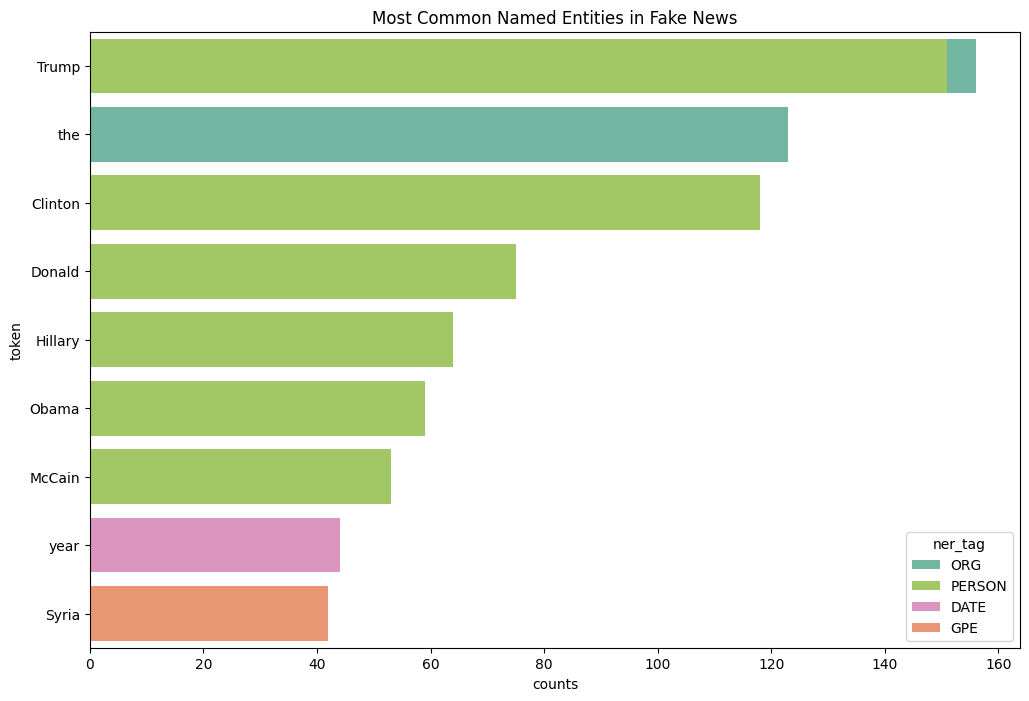

In [32]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fake[:10],
    orient = 'h',
    dodge = False
).set(title ="Most Common Named Entities in Fake News")

[Text(0.5, 1.0, 'Most Common Named Entities in Fact News')]

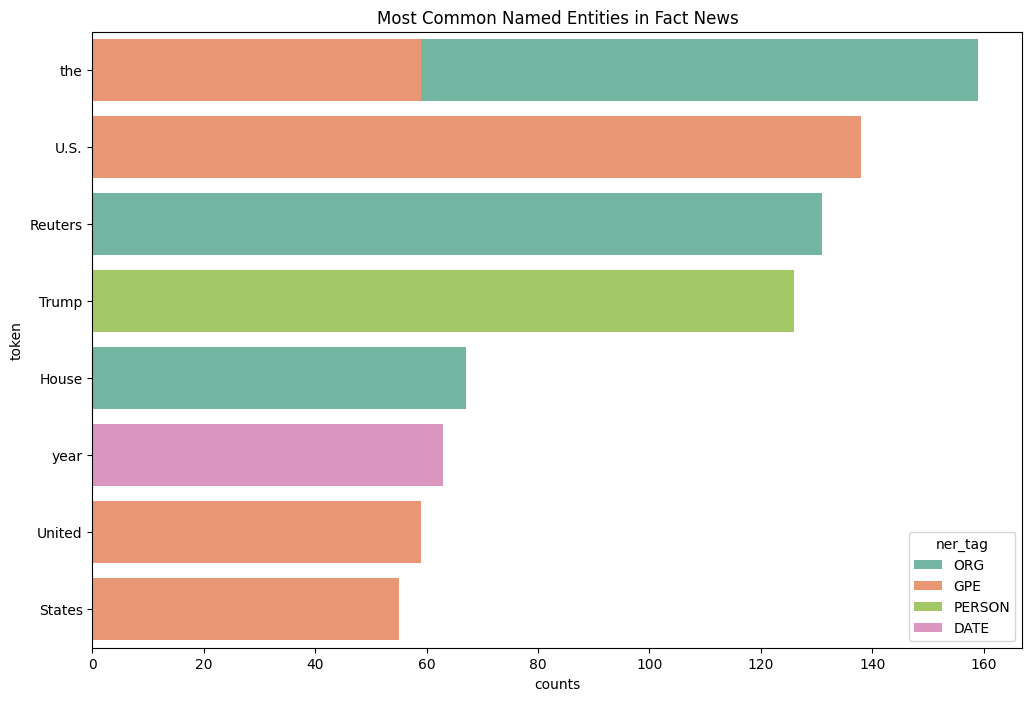

In [33]:
sns.barplot(
    x = 'counts',
    y = 'token',
    hue = 'ner_tag',
    palette = ner_palette,
    data = top_entities_fact[:10],
    orient = 'h',
    dodge = False
).set(title ="Most Common Named Entities in Fact News")

### Text `pre-processing` with some more `advance` analysis.

In [34]:
df.head()


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


#### step _1. `Reguler expression` below will look for the first hyphon and then remove the hyphon and everything before it. 
- [Reg-ex Tutorial-1](https://www.youtube.com/watch?v=sa-TUpSx1JA)
- [Reg-ex Tutorial-2](https://www.youtube.com/playlist?list=PL4cUxeGkcC9g6m_6Sld9Q4jzqdqHd2HiD)


In [35]:
# re = (lambda x :re.sub((r"^[^-]*-\s", " ",x["text"]), axis = 1 ) )

In [36]:
df.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


Removing data before hyphen as well as hyphen.

In [37]:
import re as regex
df["text_clean"] = df.apply(lambda x: regex.sub(r"^[^-]*-\s", "", x['text']), axis =1 )

In [38]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,There are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,Buried in Trump s bonkers interview with New Y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"Women make up over 50 percent of this country,..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,U.S. Defense Secretary Jim Mattis said on Mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,Northern Ireland s political parties are rapid...


### Step2. Converting it to `lower case`

In [39]:
# lower case column.
df['text_clean'] = df['text_clean'].str.lower()
# removing the punctuation. Look something that is not a word or space and removing it.


In [40]:
print(df.columns)

Index(['title', 'text', 'date', 'fake_or_factual', 'text_clean'], dtype='object')


In [41]:

df['text_clean'] = df.apply(lambda x:regex.sub(r"([^\w\s])", " ", x['text_clean']), axis = 1) # regex.sub -: reguler expression substitution.

In [42]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,there are two small problems with your analogy...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried in trump s bonkers interview with new y...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make up over 50 percent of this country ...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u s defense secretary jim mattis said on mond...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland s political parties are rapid...


In [43]:
# stop words 
en_stopwords = stopwords.words('english')
# for sw in en_stopwords:
#     print(sw, end = " ")
en_stopwords



['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

#### Step-4. Removing the `stopwords` from the df text clean column

In [44]:
df['text_clean'] = df['text_clean'].apply(lambda x : " ".join(w for w in x.split() if w not in (en_stopwords)))

In [45]:
df.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,two small problems analogy susan jesus muslim ...
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,buried trump bonkers interview new york times ...
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,women make 50 percent country grossly underrep...
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,u defense secretary jim mattis said monday rus...
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,northern ireland political parties rapidly run...


### Step-4. `Tokenizing` the data set.

In [46]:
df['text_clean'] = df['text_clean'].apply(lambda x : word_tokenize(x))

In [47]:
df['text_clean'][0] # Each entry have been tokenized.

['two',
 'small',
 'problems',
 'analogy',
 'susan',
 'jesus',
 'muslim',
 'joseph',
 'traveled',
 'bethlehem',
 'mary',
 'anyone',
 'paying',
 'attention',
 'appear',
 'many',
 'female',
 'refugees',
 'accompanying',
 'male',
 'muslim',
 'refugees',
 'greece',
 'susan',
 'sarandon',
 'spent',
 'christmas',
 'holiday',
 'greek',
 'island',
 'lesbos',
 'assisting',
 'international',
 'organizations',
 'mounting',
 'syrian',
 'refugee',
 'crisis',
 'crisis',
 'says',
 'recalls',
 'travails',
 'joseph',
 'mary',
 'way',
 'inn',
 'bethlehem',
 'column',
 'huffington',
 'post',
 'ryot',
 '69',
 'year',
 'old',
 'oscar',
 'winning',
 'actress',
 'described',
 'meeting',
 '16',
 'year',
 'old',
 'girl',
 'apparently',
 'given',
 'birth',
 'shortly',
 'arriving',
 'island',
 'smile',
 'approach',
 'without',
 'translator',
 'conversation',
 'basic',
 'friendly',
 'sarandon',
 'wrote',
 'experience',
 'takes',
 'bundle',
 'next',
 'opens',
 'inside',
 'perfect',
 'rosy',
 'newborn',
 'actress',

### Step-5. To use `Lammatizing` instead of stemming.

In [48]:
 nltk.download('wordnet')
 lemmatizer = WordNetLemmatizer()

df['text_clean']= df['text_clean'].apply(lambda x : [lemmatizer.lemmatize(token) for token in x] )


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pavankumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### The tokens has been lammatized.

In [49]:
df['text_clean'][0]

['two',
 'small',
 'problem',
 'analogy',
 'susan',
 'jesus',
 'muslim',
 'joseph',
 'traveled',
 'bethlehem',
 'mary',
 'anyone',
 'paying',
 'attention',
 'appear',
 'many',
 'female',
 'refugee',
 'accompanying',
 'male',
 'muslim',
 'refugee',
 'greece',
 'susan',
 'sarandon',
 'spent',
 'christmas',
 'holiday',
 'greek',
 'island',
 'lesbos',
 'assisting',
 'international',
 'organization',
 'mounting',
 'syrian',
 'refugee',
 'crisis',
 'crisis',
 'say',
 'recall',
 'travail',
 'joseph',
 'mary',
 'way',
 'inn',
 'bethlehem',
 'column',
 'huffington',
 'post',
 'ryot',
 '69',
 'year',
 'old',
 'oscar',
 'winning',
 'actress',
 'described',
 'meeting',
 '16',
 'year',
 'old',
 'girl',
 'apparently',
 'given',
 'birth',
 'shortly',
 'arriving',
 'island',
 'smile',
 'approach',
 'without',
 'translator',
 'conversation',
 'basic',
 'friendly',
 'sarandon',
 'wrote',
 'experience',
 'take',
 'bundle',
 'next',
 'open',
 'inside',
 'perfect',
 'rosy',
 'newborn',
 'actress',
 'contin

In [50]:
tokens_clean = sum(df['text_clean'], [])

tokens_clean[:10]

['two',
 'small',
 'problem',
 'analogy',
 'susan',
 'jesus',
 'muslim',
 'joseph',
 'traveled',
 'bethlehem']

### Step-6. Creating `N grams`.

In [51]:
unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts())
# print(unigrams[:10])
unigrams_df = unigrams.reset_index()
unigrams_df.columns = ['unigram', 'count']
# extracting the strings from tuple.
unigrams_df['unigram'] = unigrams_df['unigram'].apply(lambda x: x[0])

print(unigrams_df[:10])

      unigram  count
0       trump    612
1        said    596
2           u    314
3       state    285
4   president    275
5       would    227
6        year    184
7         one    172
8     clinton    151
9  republican    144


In [52]:
unigrams_df.head()

,unigram,count
0,trump,612
1,said,596
2,u,314
3,state,285
4,president,275


/var/folders/ry/cpzzpnh51yvfh6ctzlsm0jsw0000gn/T/ipykernel_26535/2818084446.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x ="count", y = "unigram",palette=['blue'], orient = 'h',data = unigrams_df[:10]).set(title = "Most unigram after Processing")
/var/folders/ry/cpzzpnh51yvfh6ctzlsm0jsw0000gn/T/ipykernel_26535/2818084446.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x ="count", y = "unigram",palette=['blue'], orient = 'h',data = unigrams_df[:10]).set(title = "Most unigram after Processing")


[Text(0.5, 1.0, 'Most unigram after Processing')]

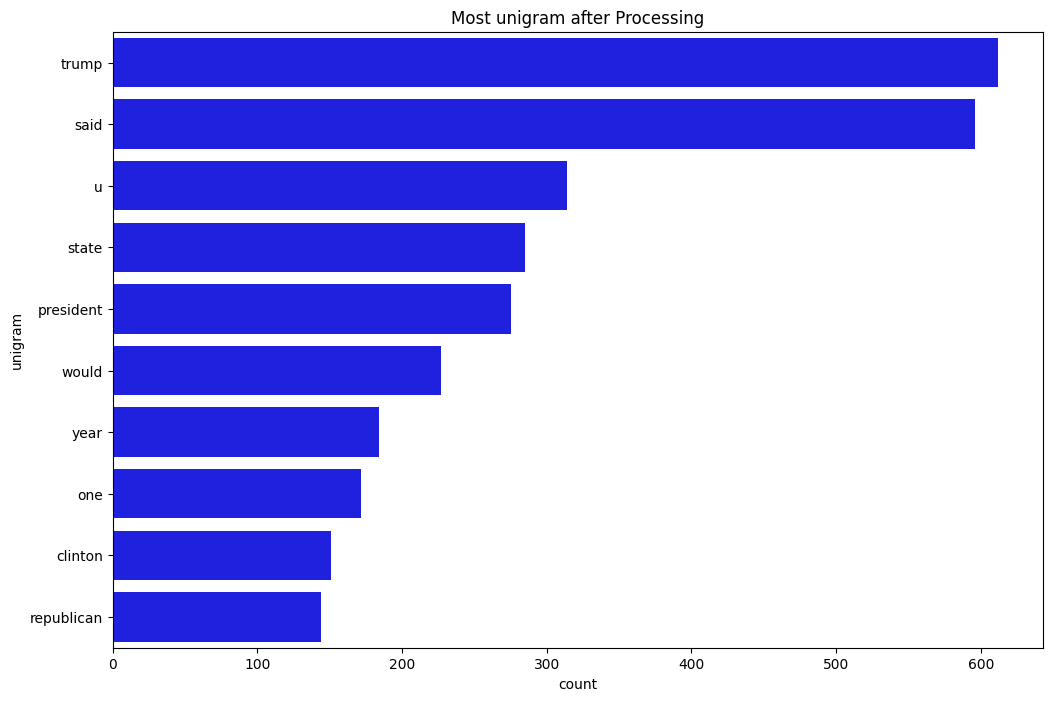

In [53]:
sns.barplot(x ="count", y = "unigram",palette=['blue'], orient = 'h',data = unigrams_df[:10]).set(title = "Most unigram after Processing")
            
            
            

#### `Bigrams`

In [54]:
bigrams = (pd.Series(nltk.ngrams(tokens_clean, 2)).value_counts())
print(bigrams[:10])
bigrams_df = bigrams.reset_index()
bigrams_df.columns = ['bigram', 'count']
# # extracting the strings from tuple.
bigrams_df['bigram'] = bigrams_df['bigram'].apply(lambda x: " ".join(x))

# print(bigrams_df[:10])

(donald, trump)        115
(united, state)         84
(white, house)          77
(president, donald)     47
(hillary, clinton)      44
(new, york)             33
(featured, image)       30
(supreme, court)        30
(year, old)             30
(image, via)            29
Name: count, dtype: int64


In [55]:
bigrams.head(), bigrams_df.head()

((donald, trump)        115
 (united, state)         84
 (white, house)          77
 (president, donald)     47
 (hillary, clinton)      44
 Name: count, dtype: int64,
              bigram  count
 0      donald trump    115
 1      united state     84
 2       white house     77
 3  president donald     47
 4   hillary clinton     44)

/var/folders/ry/cpzzpnh51yvfh6ctzlsm0jsw0000gn/T/ipykernel_26535/984966553.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x ='count', y = 'bigram', data = bigrams_df[:10], orient = 'h', palette = ['green']).set(title= 'Most famous bigrams')
/var/folders/ry/cpzzpnh51yvfh6ctzlsm0jsw0000gn/T/ipykernel_26535/984966553.py:1: UserWarning: 
The palette list has fewer values (1) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x ='count', y = 'bigram', data = bigrams_df[:10], orient = 'h', palette = ['green']).set(title= 'Most famous bigrams')


[Text(0.5, 1.0, 'Most famous bigrams')]

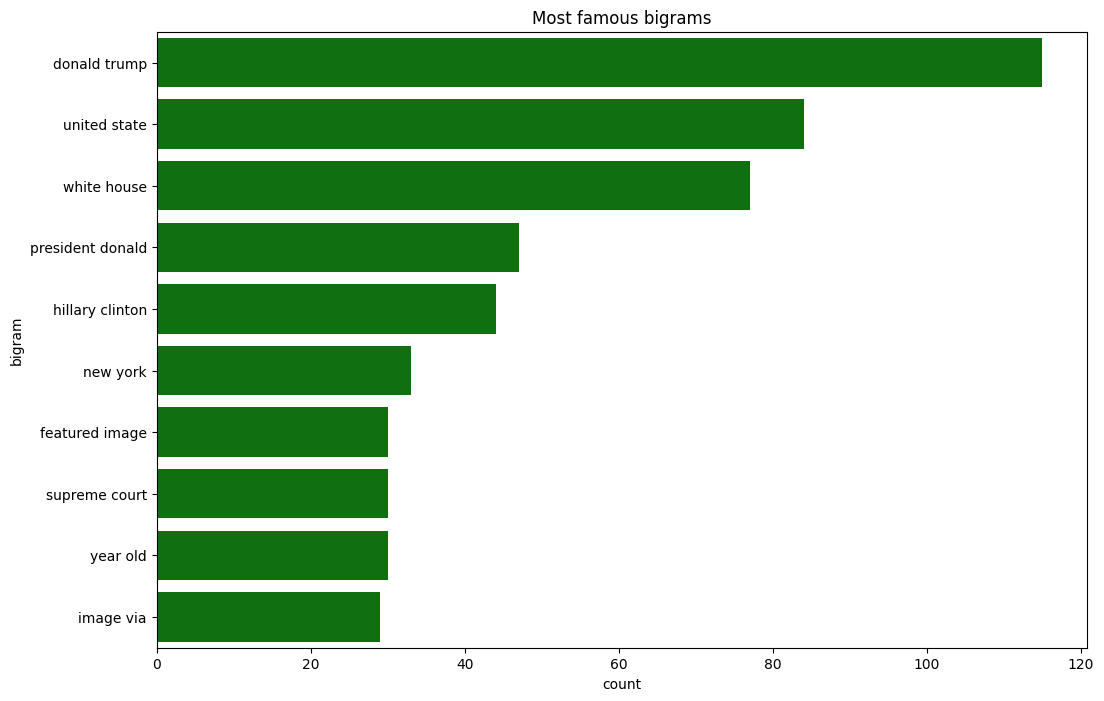

In [56]:
sns.barplot(x ='count', y = 'bigram', data = bigrams_df[:10], orient = 'h', palette = ['green']).set(title= 'Most famous bigrams')

#### `Trigrams`

In [57]:
trigrams = pd.Series(nltk.ngrams(tokens_clean, 3)).value_counts()
trigrams.head()
trigrams_df = trigrams.reset_index()
trigrams_df.columns = ['trigram', 'count']
trigrams_df['trigram'] = trigrams_df['trigram'].apply(lambda x : " ".join(x))

trigrams_df.head()

,trigram,count
0,president donald trump,46
1,featured image via,28
2,pic twitter com,26
3,president barack obama,17
4,new york time,11


[Text(0.5, 1.0, 'Most famous trigrams')]

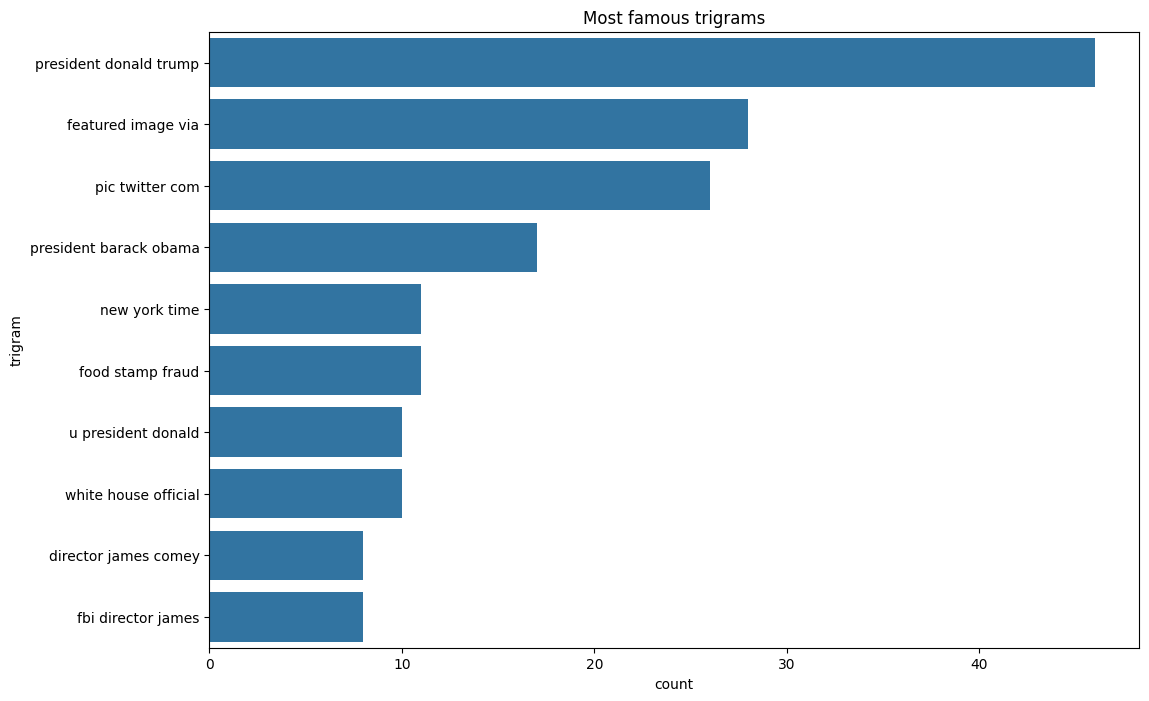

In [58]:
sns.barplot(x = 'count', y = 'trigram', data = trigrams_df[:10], orient = 'h').set(title = 'Most famous trigrams')

#### `sentiment analysis`
- How sentiment differs in the both the real and fake catagories.

In [59]:
# assisgining one more column to original df regarding the sentiment values.
vader_sentiment = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['text'].apply(lambda x: vader_sentiment.polarity_scores(x)['compound'] )

In [60]:
df.head()

,title,text,date,fake_or_factual,text_clean,sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


Creating bins for positive, negative, neutral values text assigning and this is how we can analyze the how many positive and etc.. sentiments are.

- Below I have created theree bins are following. 
- [-1,-0.1] > Negative
- [-0.1, 0.1] > Neutral
- [0.1, 1] > Positive

In [61]:
bins = [-1,-0.1, 0.1, 1 ]
names = ['Negative', 'Neutral', 'Positive']


Assigning the bins with names.

In [62]:
df['vader_sentiment_label'] = pd.cut(df['sentiment_score'] , bins = bins, labels = names)

<Axes: xlabel='vader_sentiment_label'>

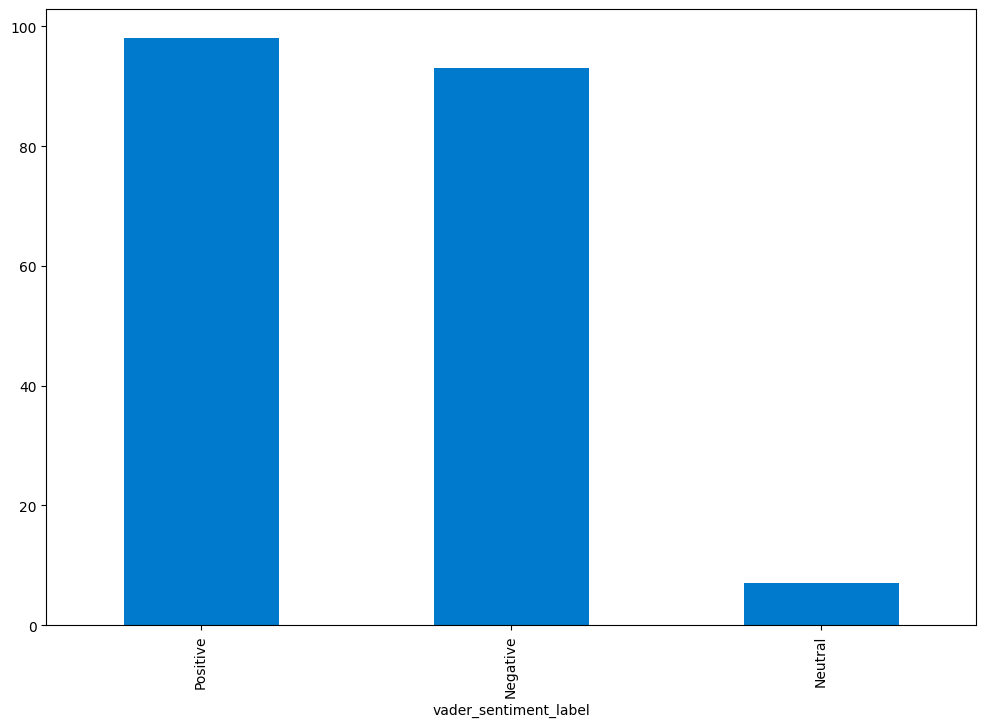

In [63]:
df['vader_sentiment_label'].value_counts().plot(kind = 'bar', color = default_plot_color)

sns plot

[Text(0.5, 1.0, ' Sentiment by news type')]

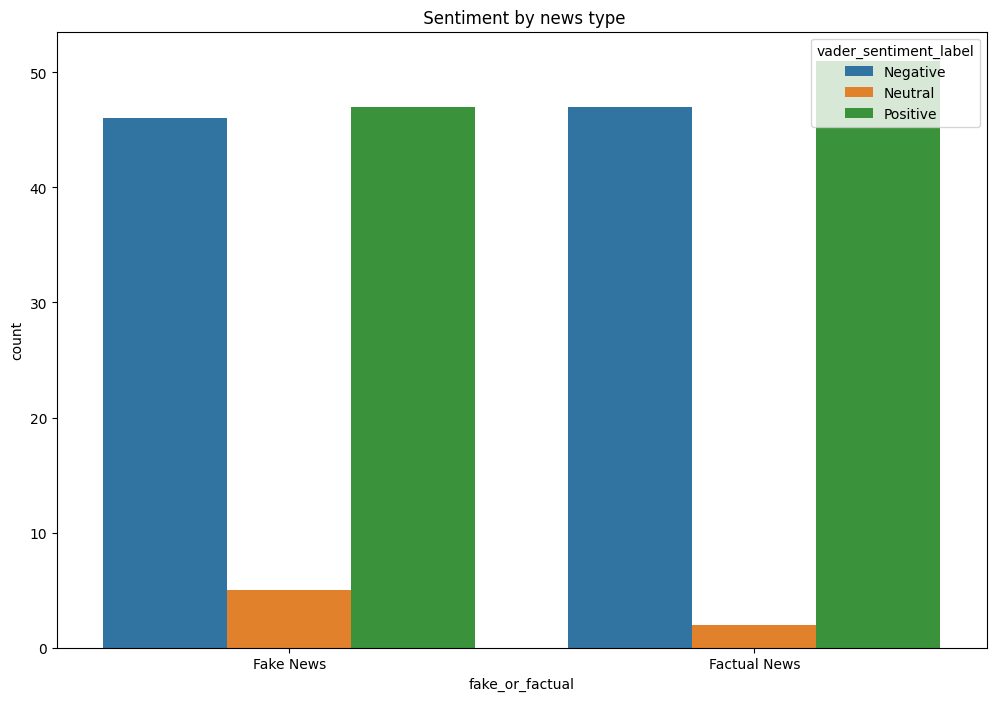

In [64]:
sns.countplot(x = "fake_or_factual", hue = 'vader_sentiment_label', data = df, ).set(title = " Sentiment by news type")

#### Topic Modeling. ** 

In [65]:
fake_news_text = df[df['fake_or_factual']=='Fake News']['text_clean'].reset_index(drop= True)
fake_news_text

0     [two, small, problem, analogy, susan, jesus, m...
1     [buried, trump, bonkers, interview, new, york,...
2     [woman, make, 50, percent, country, grossly, u...
3     [shame, teen, vogue, maxine, water, guest, tee...
4     [former, white, house, press, secretary, obama...
                            ...                        
93    [jon, ritzheimer, infamous, hater, muslim, one...
94    [well, take, long, look, first, beastiality, m...
95    [florida, toxic, dangerous, stand, ground, gun...
96    [politico, report, almost, neck, neck, race, h...
97    [small, obscure, community, college, disallowi...
Name: text_clean, Length: 98, dtype: object

In [66]:
dictionary_fake = corpora.Dictionary(fake_news_text)


In [67]:
doc_term_fake = [dictionary_fake.doc2bow(text) for text in fake_news_text]

In [68]:
coherence_values = []
model_list = []

min_topics = 2
max_topics = 11


for num_topics_i in range(min_topics, max_topics+1):
    model = gensim.models.LdaModel(doc_term_fake, num_topics = num_topics_i, id2word = dictionary_fake)
    model_list.append(model)
    Coherence_model = CoherenceModel(model = model, texts= fake_news_text, dictionary = dictionary_fake, coherence = 'c_v')
    coherence_values.append(Coherence_model.get_coherence())

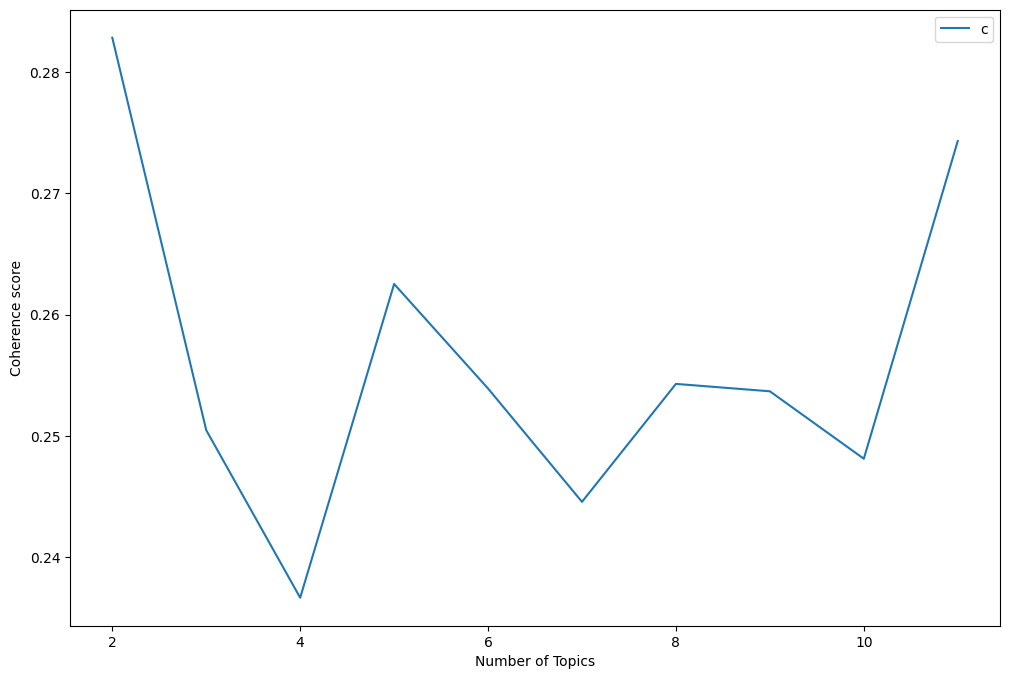

In [69]:
plt.plot(range(min_topics, max_topics + 1), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [70]:
num_topics_lda = 7
lda_model = gensim.models.LdaModel(corpus = doc_term_fake, id2word = dictionary_fake, num_topics= num_topics_lda)

In [73]:
lda_model.print_topics(num_topics = num_topics_lda, num_words = 10)


[(0,
  '0.009*"trump" + 0.008*"said" + 0.007*"president" + 0.005*"u" + 0.004*"time" + 0.004*"state" + 0.003*"student" + 0.003*"one" + 0.003*"republican" + 0.003*"school"'),
 (1,
  '0.014*"trump" + 0.005*"would" + 0.004*"republican" + 0.004*"u" + 0.004*"said" + 0.004*"clinton" + 0.004*"president" + 0.004*"one" + 0.003*"woman" + 0.003*"time"'),
 (2,
  '0.009*"trump" + 0.007*"u" + 0.005*"year" + 0.004*"president" + 0.004*"state" + 0.003*"said" + 0.003*"mccain" + 0.003*"would" + 0.003*"people" + 0.002*"one"'),
 (3,
  '0.009*"trump" + 0.005*"one" + 0.004*"said" + 0.004*"state" + 0.004*"u" + 0.003*"president" + 0.003*"republican" + 0.003*"mccain" + 0.003*"obama" + 0.003*"would"'),
 (4,
  '0.009*"trump" + 0.005*"president" + 0.005*"said" + 0.004*"state" + 0.004*"year" + 0.004*"time" + 0.004*"clinton" + 0.004*"donald" + 0.004*"hillary" + 0.003*"would"'),
 (5,
  '0.020*"trump" + 0.005*"clinton" + 0.005*"one" + 0.005*"said" + 0.004*"president" + 0.004*"state" + 0.003*"donald" + 0.003*"woman" + 0